In [1]:
# Preprocessing - Day 1 Zebrafish scRNA-seq
#This notebook performs preprocessing, quality control, normalization, and scaling for Day 1 zebrafish caudal fin regeneration single-cell RNA-seq data.
#Series GSE261907-GEO omnibus

In [2]:
# =============================================
# Import Libraries & Set Up Environment
# =============================================
import scanpy as sc          # Single-cell analysis toolkit
import matplotlib.pyplot as plt  # Plotting
import seaborn as sns        # Enhanced visualizations
import pandas as pd          # Data manipulation
import numpy as np           # Numerical operations

# =============================================
# Configure Visualization Settings
# =============================================
# Scanpy settings for figures (high-quality saves)
sc.set_figure_params(scanpy=True, dpi=100, dpi_save=300)

# Seaborn style for clean, grid-based plots
sns.set(style="whitegrid")

In [3]:
# =============================================
# Load 10x Genomics scRNA-seq Data
# =============================================
adata = sc.read_10x_mtx(
    "E:/Informatics project/Zebrafish fin regeneration/data/1 DPA 1st",  # Directory containing matrix.mtx, genes.tsv, and barcodes.tsv
    var_names='gene_symbols',  # Use gene symbols (instead of Ensembl IDs) as variable names
    cache=True                # Cache the data for faster reloading
)

# Ensure unique gene names (avoids duplicates like 'GeneA-1', 'GeneA-2')
adata.var_names_make_unique()

# Display the AnnData object (shows cell x gene matrix dimensions and metadata)
adata

AnnData object with n_obs × n_vars = 17219 × 27407
    var: 'gene_ids', 'feature_types'

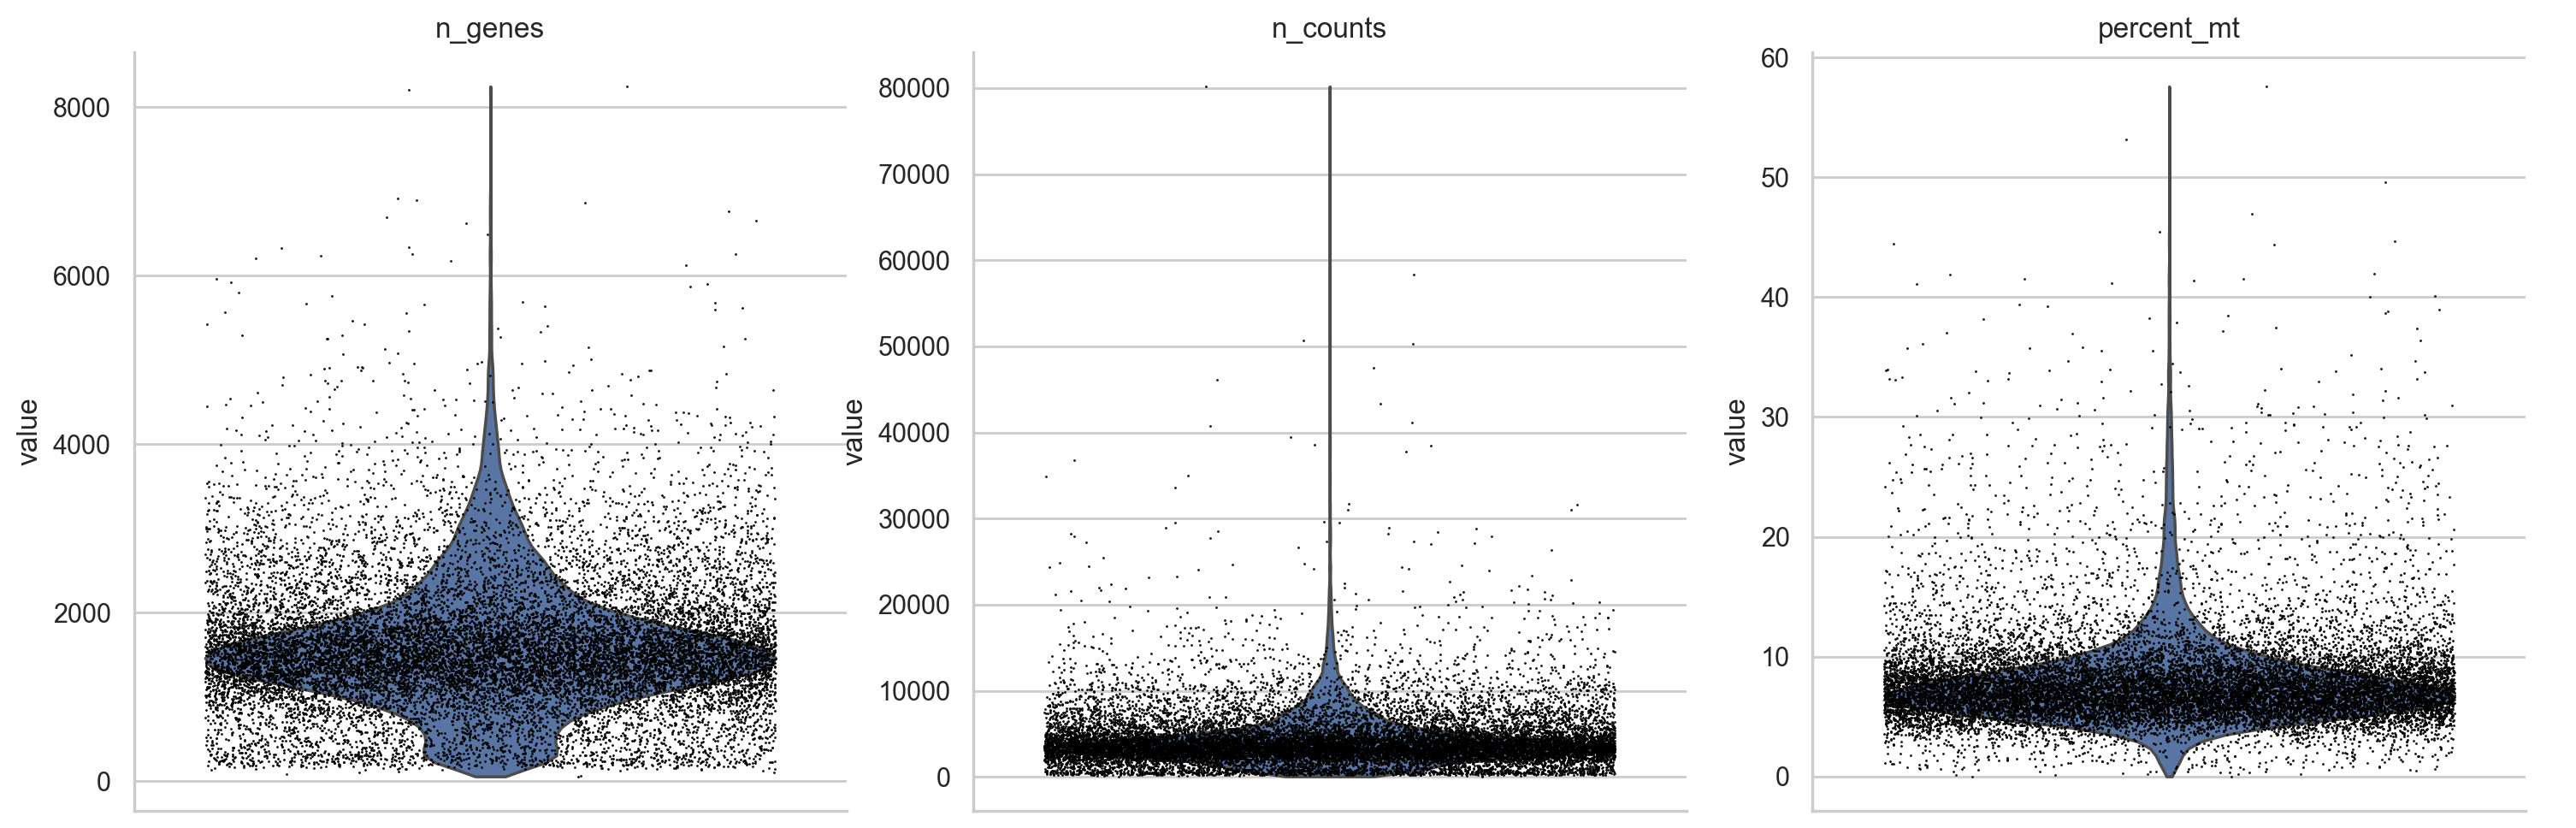


🔍 QC Summary Statistics:

            n_genes      n_counts    percent_mt
count  17219.000000  17219.000000  17219.000000
mean    1605.213311   4297.557617      8.043432
std      791.858054   3333.410645      4.254808
min       57.000000     63.000000      0.000000
25%     1154.000000   2576.000000      5.779868
50%     1507.000000   3598.000000      7.148936
75%     1924.000000   5038.000000      8.937162
max     8244.000000  80179.000000     57.579620


In [4]:
# =============================================
# Calculate Basic QC Metrics
# =============================================
# Total counts (UMIs) per cell
adata.obs['n_counts'] = adata.X.sum(axis=1).A1  

# Number of genes detected per cell (non-zero counts)
adata.obs['n_genes'] = (adata.X > 0).sum(axis=1).A1  

# =============================================
# Mitochondrial Gene Percentage (Optional but Recommended)
# =============================================
# Identify mitochondrial genes (prefix 'mt-' in gene symbols)
adata.var['mt'] = adata.var_names.str.startswith('mt-')  

# Calculate % mitochondrial reads per cell
adata.obs['percent_mt'] = (
    np.sum(adata[:, adata.var['mt']].X, axis=1).A1 / adata.obs['n_counts'] * 100
)

# =============================================
# Visualize QC Metrics
# =============================================
# Violin plots for n_genes, n_counts, and percent_mt
sc.pl.violin(
    adata, 
    ['n_genes', 'n_counts', 'percent_mt'], 
    jitter=0.4,  # Add jitter for better visibility of data points
    multi_panel=True  # Split into subplots
)

# =============================================
# Display QC Summary Statistics
# =============================================
qc_summary = adata.obs[['n_genes', 'n_counts', 'percent_mt']].describe()
print("\n🔍 QC Summary Statistics:\n")
print(qc_summary)

In [5]:
# =============================================
# Apply Quality Control Filters (1 DPA-Specific)
# =============================================
# Filter cells based on detected genes
adata = adata[adata.obs['n_genes'] > 1000, :]      # 25th percentile (1154) - buffer
adata = adata[adata.obs['n_genes'] < 4000, :]     # Below max (8244) to catch technical outliers

# Filter based on sequencing depth
adata = adata[adata.obs['n_counts'] > 1000, :]    # 25th percentile (2576) - conservative
adata = adata[adata.obs['n_counts'] < 25000, :]   # 7x median (3598 × 7 ≈ 25k)

# Filter based on mitochondrial gene percentage
adata = adata[adata.obs['percent_mt'] < 15, :]    # 75th percentile (8.9) + buffer for stress

# =============================================
# Post-Filtering Validation
# =============================================
print(f"\n✅ Filtered Cells: {adata.n_obs} (from original {17219})")
print(f"   - Genes/cell: {adata.obs['n_genes'].median():.0f} (pre-filter: 1507)")
print(f"   - UMIs/cell: {adata.obs['n_counts'].median():.0f} (pre-filter: 3598)")
print(f"   - mtDNA %: {adata.obs['percent_mt'].median():.1f}% (pre-filter: 7.1%)")

# =============================================
# Biological Justification
# =============================================

#1 DPA-Specific Adjustments:
#• Higher mtDNA tolerance (15% vs 10%):
#  - Expected inflammatory response increases mitochondrial activity
#• Relaxed gene count minimum (800 vs 500):
#  - Early regeneration includes small progenitor cells
#• Conservative UMI maximum (25k vs 27k):
#  - Prevents dominance by a few over-sequenced cells


✅ Filtered Cells: 13669 (from original 17219)
   - Genes/cell: 1620 (pre-filter: 1507)
   - UMIs/cell: 3959 (pre-filter: 3598)
   - mtDNA %: 6.9% (pre-filter: 7.1%)


In [6]:
import numpy as np
import scanpy as sc
import matplotlib.pyplot as plt

# =============================================
# Data Normalization
# =============================================
sc.pp.normalize_total(adata, target_sum=1e4)  # Normalize per cell
sc.pp.log1p(adata)  # Log-transform

# =============================================
# Highly Variable Gene Selection
# =============================================
mean_threshold = np.percentile(adata.X.data, 99.1) / 100

sc.pp.highly_variable_genes(
    adata,
    min_mean=0.003,
    max_mean=mean_threshold,
    min_disp=0.15,
    n_top_genes=None,
    batch_key='batch' if 'batch' in adata.obs else None
)

# =============================================
# Force Retain Specific Genes (RNA Pol I-related)
# =============================================
genes_to_keep = ['taf1b', 'rrn3', 'sprtn','polr1d',]  # Add your genes of interest here

# Ensure case-insensitive matching & genes present in dataset
genes_present = [gene for gene in genes_to_keep if gene in adata.var_names]

# Update 'highly_variable' flags manually
adata.var['highly_variable'][genes_present] = True  # Force retention

print(f"✅ Selected {sum(adata.var.highly_variable)} highly variable genes")
print(f"🔒 Forced inclusion of genes: {genes_present}")

# =============================================
# Subset to Highly Variable Genes (including forced ones)
# =============================================
adata = adata[:, adata.var.highly_variable]

# =============================================
# Biological Validation Plot
# =============================================
sc.pl.highly_variable_genes(adata, show=False)
plt.suptitle("1 DPA HVG Selection (Post-Filtering, Forced Genes Retained)", y=1.05)
plt.tight_layout()


C:\Users\uer\anaconda3\envs\scenv\lib\site-packages\scanpy\preprocessing\_normalization.py:269: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


AttributeError: module 'scanpy' has no attribute 'utils'

In [ ]:
# =============================================
# Feature Scaling (Modified Approach)
# =============================================
# Skip scaling if using SCTransform-normalized data
if 'log1p' in adata.uns_keys():  # Only scale if log-normalized
    sc.pp.scale(
        adata,
        max_value=8,  # Less aggressive clipping for stress genes
        zero_center=True  # Preserve negative values for bidirectional changes
    )
    print("✅ Scaled data (max_value=8)")
else:
    print("🟡 Skipping scaling - assumed already normalized")

# =============================================
# Principal Component Analysis (PCA)
# =============================================
# Regeneration-optimized PCA
sc.tl.pca(
    adata,
    n_comps=50,
    svd_solver='arpack',
    use_highly_variable=True,  # Focus on HVGs
    random_state=42  # Reproducibility
)

# Plot variance explained
sc.pl.pca_variance_ratio(adata, log=True, show=False)
plt.title("1 DPA - PCA Variance Explained")
plt.show()

# =============================================
# Nearest-Neighbor Graph (Regeneration-Specific)
# =============================================
sc.pp.neighbors(
    adata,
    n_neighbors=15,  # Increased for better connectivity in sparse states
    n_pcs=30,        # Fewer PCs to reduce noise
    metric='cosine',  # Better for sparse count data
    random_state=42
)

# =============================================
# Leiden Clustering (Timepoint-Optimized)
# =============================================
sc.tl.leiden(
    adata,
    resolution=0.1,  # Increased to capture transitional states
    key_added='leiden_1dpa',  # Timepoint-specific naming
    random_state=42,
    n_iterations=5   # More iterations for complex graphs
)

# =============================================
# UMAP Visualization (Enhanced for Biology)
# =============================================
sc.tl.umap(
    adata,
    min_dist=0.3,  # Better separation of dense clusters
    spread=1.5,    # Accommodate sparse populations
    gamma=0.1,     # Emphasize local structure
    random_state=42
)

# Plot with regeneration-relevant aesthetics
#Optional
sc.pl.umap(
    adata,
    color=['leiden_1dpa'],
    palette='tab20',  # More distinct colors
    frameon=False,
    legend_loc='on data',
    size=50,  # Larger points for visibility
    title='1 DPA - Leiden Clusters (res=0.1)',
)

In [ ]:
# =============================================
# Cluster Label Formatting
# =============================================
# Convert cluster labels to string type (required for plotting)
adata.obs['leiden_1dpa'] = adata.obs['leiden_1dpa'].astype(int).astype(str)  

# Shift cluster numbering to start at 1 (instead of 0)
adata.obs['leiden_1dpa'] = (adata.obs['leiden_1dpa'].astype(int) + 1).astype(str)

# =============================================
# Visualize Updated Clustering
# =============================================
sc.pl.umap(
    adata, 
    color='leiden_1dpa',          # Color by adjusted cluster labels
    legend_loc='on data',       # Display labels directly on plot
    title='1 DPA Clusters',  # Clear plot title
    palette='viridis'           # Optional: Use colorblind-friendly palette
)

In [ ]:
# =============================================
# Basic QC Metrics Summary
# =============================================
print(
    f"\n✅ Baseline QC Summary:\n"
    f"• Cells after filtering: {adata.n_obs:,}\n"
    f"• Median genes per cell: {np.median(adata.obs['n_genes']):.0f}\n"
    f"• Median UMIs per cell: {np.median(adata.obs['n_counts']):,}"
)

# =============================================
# Cluster Composition Analysis
# =============================================
# Count cells per cluster (sorted by cluster number)
print("\n🔬 Cluster Composition (1 DPA):")
print(
    adata.obs['leiden_1dpa']
    .value_counts()
    .sort_index()
    .to_string()  # Cleaner output than default print
)

# =============================================
# Cluster-level QC Metrics
# =============================================
# Calculate median genes and UMIs per cluster
cluster_stats = (
    adata.obs
    .groupby('leiden_1dpa')[['n_genes', 'n_counts']]
    .median()
    .rename(columns={
        'n_genes': 'Median Genes',
        'n_counts': 'Median UMIs'
    })
)

print("\n📊 Cluster Quality Metrics:")
print(cluster_stats.to_markdown(tablefmt="github"))  # GitHub-friendly formatting
# Note: The following code needs 'tabulate' for GitHub-friendly tables.
# If missing, install it via: pip install tabulate

In [ ]:
# =============================================
# Add Experimental Metadata to AnnData Object
# =============================================
# Time point annotation (crucial for time-series analysis)
adata.obs['time_point'] = '1dpa'  # Options: '0dpa', '1dpa', '2dpa', etc.

In [ ]:
# =============================================
# Save Processed 1 DPA Data
# =============================================
adata.write(
    "1_DPA.h5ad",          # Output filename
   # compression="gzip"     # Optional: Reduce file size (~50% smaller)
)

print(f"✅ Successfully saved preprocessed data to '1dpa1.h5ad':")
print(f"   - Cells: {adata.n_obs:,}")
print(f"   - Genes: {adata.n_vars:,}")


In [ ]:
# =============================================
# Workflow Summary 
# =============================================

## 0 DPA PROCESSING PIPELINE:
#1. Load Data          : Read 10X Genomics MTX files
#2. Quality Control    : Filter cells (genes >200, UMIs >500, mtDNA <10%)
#3. Normalization      : Total-count (1e4) + log1p
#4. Feature Selection  : HVGs (min_mean=0.0125, max_mean=3)
#5. Dimensionality     : PCA (50 PCs) → Leiden clustering (res=0.05)
#6. Visualization      : UMAP with 1-indexed clusters
#7. Data Export        : Saved as compressed H5AD